In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [2]:
df = pd.read_csv('./data/Log_Data.csv')

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')
df.head()

,timestamp,Oak_logs,Willow_logs,Maple_logs,Yew_logs
0,2021-04-30,57,19,11,236
1,2021-05-01,58,19,11,234
2,2021-05-02,61,19,11,230
3,2021-05-03,65,19,11,227
4,2021-05-04,69,19,11,224


In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size,i)
        #Reshape our data to (history_Size,1)
        data.append(np.reshape(dataset[indices],(history_size,1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 120

In [6]:
tf.random.set_seed(13)

In [7]:
# Test 1: Chaos Runes, Univariate Timeseries test

uni_data = df['Willow_logs']

uni_data.index = df['timestamp']

uni_data.head()

timestamp
2021-04-30    19
2021-05-01    19
2021-05-02    19
2021-05-03    19
2021-05-04    19
Name: Willow_logs, dtype: int64

array([<AxesSubplot:xlabel='timestamp'>], dtype=object)

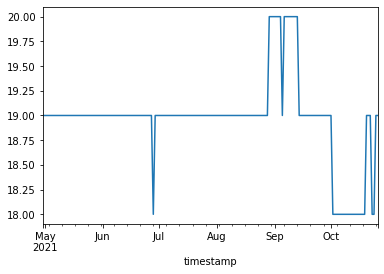

In [8]:
uni_data.plot(subplots=True)


In [9]:
uni_data = uni_data.values

In [10]:
# normalize features by applying coefficent of variation. subtracting mean and dividing by standard dev
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()


In [11]:
# normalized data, coefficent of variation
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [12]:
# Univariate model. We feed the Model the last 10 records, it needs to learn to predict the next upcoming record
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0 ,TRAIN_SPLIT,
                                          univariate_past_history,
                                          univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data,TRAIN_SPLIT, None,
                                      univariate_past_history,
                                      univariate_future_target)

In [13]:
print('single window of past history')
print(x_train_uni[0])
print('\n target to predict')
print(y_train_uni[0])

single window of past history
[[0.09166985]
 [0.09166985]
 [0.09166985]
 [0.09166985]
 [0.09166985]
 [0.09166985]
 [0.09166985]
 [0.09166985]
 [0.09166985]
 [0.09166985]]

 target to predict
0.09166984970281591


In [14]:
# Create time step
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [15]:
def show_plot (plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-' , 'rx' ,'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize = 10,
                     label= labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-step')
        return plt
            
            
    
    

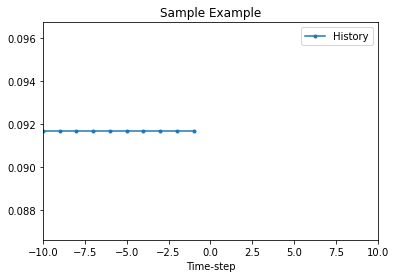

In [16]:
plot = show_plot([x_train_uni[0],y_train_uni[0]], 0, 'Sample Example')
plot.show()

In [17]:
# BASELINE

In [18]:
def baseline(history):
    return np.mean(history)

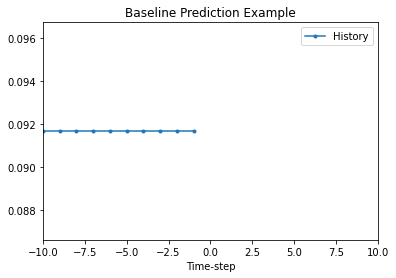

In [19]:
plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, "Baseline Prediction Example")
plot.show()

In [20]:
# Apply Recurring neural network to Rune's Dataset

In [21]:
BATCH_SIZE = 20
BUFFER_SIZE = 5

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()



In [22]:
# Long short term memory Neural network, Tensorflow
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss = 'mae')

In [23]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(20, 1)


In [24]:
EVALUATION_INTERVAL = 500
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs = EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                     validation_data = val_univariate, validation_steps=50)

Epoch 1/20
500/500 [==============================] - 2s 5ms/step - loss: 0.1035 - val_loss: 6.0871
Epoch 2/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1015 - val_loss: 6.0891
Epoch 3/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1003 - val_loss: 6.0897
Epoch 4/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1003 - val_loss: 6.0835
Epoch 5/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1016 - val_loss: 6.0824
Epoch 6/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1003 - val_loss: 6.0784
Epoch 7/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1003 - val_loss: 6.0736
Epoch 8/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1014 - val_loss: 6.0724
Epoch 9/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1003 - val_loss: 6.0710
Epoch 10/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1002 - val_loss: 6.0708

In [25]:
# Loss is decreasing, this is probably due to a case of overfitting..... 

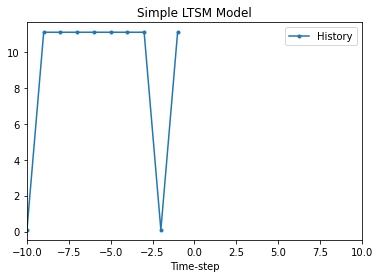

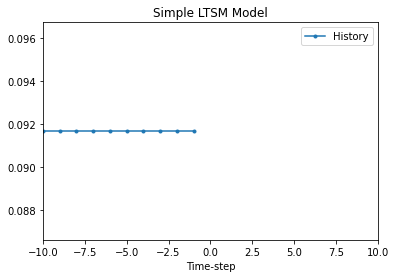

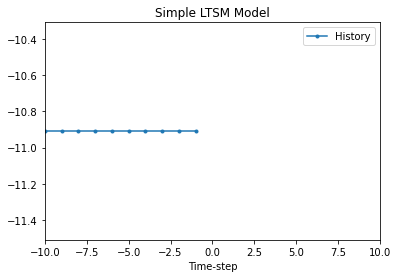

In [26]:
# Predict with LSTM Model

for x,y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                  simple_lstm_model.predict(x)[0]], 0, 'Simple LTSM Model')
    plot.show()

In [27]:
# Our model did not perform the best..... We should consider adding new features.


In [28]:
add_features=['Yew_logs', 'Maple_logs', 'Oak_logs']

In [29]:
features = df[add_features]
features.index = df['timestamp']

features.head()

,Yew_logs,Maple_logs,Oak_logs
timestamp,,,
2021-04-30,236,11,57
2021-05-01,234,11,58
2021-05-02,230,11,61
2021-05-03,227,11,65
2021-05-04,224,11,69


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>], dtype=object)

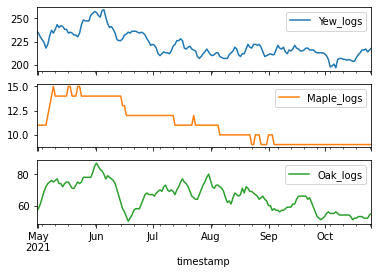

In [30]:
features.plot(subplots = True)

In [31]:
dataset = features.values

data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [32]:
#  coefficent of variation 
dataset = (dataset-data_mean/data_std)

In [33]:
# now that our data is cv, lets try and predict 1 day ahead. with a multivariated data

In [34]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indicies = range(i-history_size, i ,step)
        data.append(dataset[indicies])
    
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        
    return np.array(data), np.array(labels)

In [35]:
# Split into training and test sets, shuffle and Batch repeat them once more. finally create a simple lstm model.
past_history = 10
future_target = 1

STEP = 1 

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [36]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 3)


In [37]:

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [38]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                          input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = 'mae')

In [39]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(20, 1)


In [40]:
single_step_history = single_step_model.fit(train_data_single, epochs = EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                           validation_data=val_data_single,
                                           validation_steps=50)

Epoch 1/20
500/500 [==============================] - 2s 5ms/step - loss: 1.9923 - val_loss: 2.2317
Epoch 2/20
500/500 [==============================] - 2s 4ms/step - loss: 1.2260 - val_loss: 1.3819
Epoch 3/20
500/500 [==============================] - 2s 4ms/step - loss: 0.7838 - val_loss: 1.3224
Epoch 4/20
500/500 [==============================] - 2s 4ms/step - loss: 0.5811 - val_loss: 1.5248
Epoch 5/20
500/500 [==============================] - 2s 4ms/step - loss: 0.4605 - val_loss: 1.4863
Epoch 6/20
500/500 [==============================] - 2s 4ms/step - loss: 0.4096 - val_loss: 1.1055
Epoch 7/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3637 - val_loss: 1.4861
Epoch 8/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3660 - val_loss: 1.3877
Epoch 9/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3528 - val_loss: 1.4097
Epoch 10/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3342 - val_loss: 1.3130

In [41]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

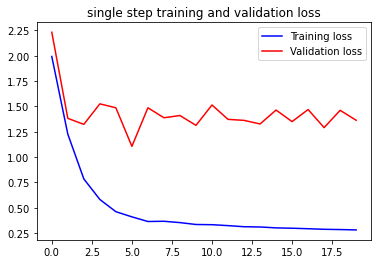

In [42]:
plot_train_history(single_step_history,
                  'single step training and validation loss')

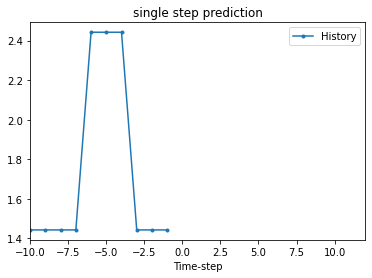

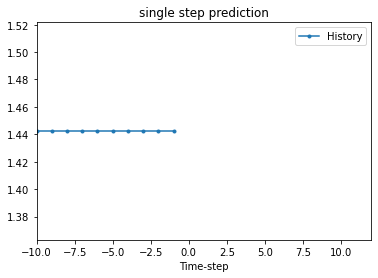

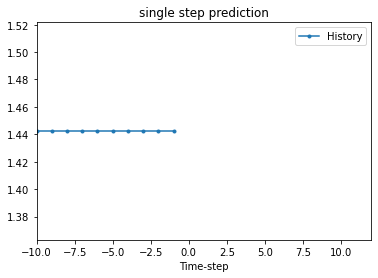

In [43]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(),y[0].numpy(),
                      single_step_model.predict(x)[0]], 1,
                     'single step prediction')
    plot.show()